In [ ]:
#!pip install numpy scikit-learn joblib pandas

In [ ]:
import numpy
import pandas as ps
import sklearn
import joblib
print(f"Phiên bản NumPy được dùng để huấn luyện: {numpy.__version__}")
print(f"Phiên bản Pandas được dùng để huấn luyện: {ps.__version__}")
print(f"Phiên bản sklearn được dùng để huấn luyện: {sklearn.__version__}")
print(f"Phiên bản joblib được dùng để huấn luyện: {joblib.__version__}")

Phiên bản NumPy được dùng để huấn luyện: 2.0.2
Phiên bản Pandas được dùng để huấn luyện: 2.2.2
Phiên bản sklearn được dùng để huấn luyện: 1.6.1
Phiên bản joblib được dùng để huấn luyện: 1.5.2


**LÀM SẠCH VÀ MÔ TẢ DỮ LIỆU**

In [ ]:
# Cài đặt và import
!apt-get install openjdk-8-jdk-headless -qq > /dev/null && pip install -q pyspark gdown

import os, sys, gdown
import pyspark
from pyspark.sql import SparkSession

# Cấu hình môi trường
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = os.path.dirname(pyspark.__file__)

# Khởi tạo Spark
spark = SparkSession.builder.appName("ReadCSV").master("local[*]").config("spark.driver.memory", "4g").getOrCreate()
print(f"Spark {spark.version} ready!")

# Download file
url = 'https://drive.google.com/file/d/1crfRjgmZfFhAFaz4DHJls5MEGz31yocD/view?usp=sharing'
file_id = url.split('/d/')[1].split('/')[0]
local_path = '/tmp/data.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', local_path, quiet=False)
print(f" Size: {os.path.getsize(local_path)/(1024*1024):.2f} MB")

# Đọc và hiển thị
df = spark.read.csv(local_path, header=True, inferSchema=True, encoding='ISO-8859-1')
df.show(20)

Spark 3.5.1 ready!


Downloading...
From: https://drive.google.com/uc?id=1crfRjgmZfFhAFaz4DHJls5MEGz31yocD
To: /tmp/data.csv
100%|██████████| 3.74M/3.74M [00:00<00:00, 238MB/s]


 Size: 3.57 MB
+-----------+-------+---+------+----------+-------------+------+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+--------------------+---------------------+----------------------+-----+----------------+
|customer_id|vintage|age|gender|dependents|   occupation|  city|customer_nw_category|branch_code|current_balance|previous_month_end_balance|average_monthly_balance_prevQ|average_monthly_balance_prevQ2|current_month_credit|previous_month_credit|current_month_debit|previous_month_debit|current_month_balance|previous_month_balance|churn|last_transaction|
+-----------+-------+---+------+----------+-------------+------+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+-------------

In [ ]:
#Xem cấu trúc dữ liệu
df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- vintage: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- dependents: double (nullable = true)
 |-- occupation: string (nullable = true)
 |-- city: double (nullable = true)
 |-- customer_nw_category: integer (nullable = true)
 |-- branch_code: integer (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- previous_month_end_balance: double (nullable = true)
 |-- average_monthly_balance_prevQ: double (nullable = true)
 |-- average_monthly_balance_prevQ2: double (nullable = true)
 |-- current_month_credit: double (nullable = true)
 |-- previous_month_credit: double (nullable = true)
 |-- current_month_debit: double (nullable = true)
 |-- previous_month_debit: double (nullable = true)
 |-- current_month_balance: double (nullable = true)
 |-- previous_month_balance: double (nullable = true)
 |-- churn: integer (nullable = true)
 |-- last_transaction: string (nullable

In [ ]:
# Xem thống kê cơ bản
df.summary().show()

+-------+------------------+------------------+------------------+------+-------------------+----------+------------------+--------------------+-----------------+------------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+--------------------+---------------------+----------------------+-------------------+----------------+
|summary|       customer_id|           vintage|               age|gender|         dependents|occupation|              city|customer_nw_category|      branch_code|   current_balance|previous_month_end_balance|average_monthly_balance_prevQ|average_monthly_balance_prevQ2|current_month_credit|previous_month_credit|current_month_debit|previous_month_debit|current_month_balance|previous_month_balance|              churn|last_transaction|
+-------+------------------+------------------+------------------+------+-------------------+----------+------------------+-----

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum
#Chuyển đổi sang kiểu TimestampType
# Convert 'last_transaction' to date type and handle potential errors
df = df.withColumn("last_transaction", col("last_transaction").cast("timestamp"))

#Missing value
# Tạo list các cột với số lượng null
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c)
                         for c in df.columns])

# Display null counts using show() for PySpark DataFrame
null_counts.show()

+-----------+-------+---+------+----------+----------+----+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+--------------------+---------------------+----------------------+-----+----------------+
|customer_id|vintage|age|gender|dependents|occupation|city|customer_nw_category|branch_code|current_balance|previous_month_end_balance|average_monthly_balance_prevQ|average_monthly_balance_prevQ2|current_month_credit|previous_month_credit|current_month_debit|previous_month_debit|current_month_balance|previous_month_balance|churn|last_transaction|
+-----------+-------+---+------+----------+----------+----+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+--------------------+---------------------+

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# --- Tính mode cho gender ---
gender_mode_row = df.filter(col('gender').isNotNull()) \
                    .groupBy('gender').count() \
                    .orderBy(F.desc('count')) \
                    .first()
gender_mode = gender_mode_row['gender'] if gender_mode_row else 'Unknown'

# --- Tính median cho dependents ---
df = df.withColumn("dependents", col("dependents").cast("float"))
dependents_median = df.approxQuantile("dependents", [0.5], 0.01)[0]

# --- Tính mode cho city ---
city_mode_row = df.filter(col('city').isNotNull()) \
                  .groupBy('city').count() \
                  .orderBy(F.desc('count')) \
                  .first()
city_mode = city_mode_row['city'] if city_mode_row else 'Unknown'

# --- Xóa các dòng dữ liệu null cho transaction ---
df = df.na.drop(subset=["last_transaction"])

# --- Điền các giá trị thiếu ---
df = df.fillna({
    'gender': gender_mode,
    'dependents': dependents_median,
    'occupation': 'Unknown',
    'city': city_mode
})

#Chuyển đổi city và dependents về integer
df = df.withColumn("city", col("city").cast("integer"))
df = df.withColumn("dependents", col("dependents").cast("integer"))

# --- Kiểm tra lại ---
for column in ['gender', 'dependents', 'occupation', 'city', 'last_transaction']:
    null_count = df.filter(col(column).isNull()).count()
    print(f"{column}: {null_count}")

gender: 0
dependents: 0
occupation: 0
city: 0
last_transaction: 0


In [ ]:
#Kiểm tra nếu data có dupilacted
total_rows = df.count()
distinct_rows = df.distinct().count()  # hoặc df.dropDuplicates().count()
duplicated_count = total_rows - distinct_rows

print(f"Số dòng trùng lặp: {duplicated_count}")

Số dòng trùng lặp: 0


In [ ]:
from pyspark.sql.functions import col
from functools import reduce
#Tìm dòng chứa ký tự ? hoặc ,

# Tạo điều kiện cho từng cột
conditions = []
for column in df.columns:
    # Cast sang string và kiểm tra chứa ? hoặc ,
    condition = col(column).cast('string').rlike(r'\?|,')
    conditions.append(condition)

# Kết hợp tất cả điều kiện
combined = reduce(lambda a, b: a | b, conditions)

# Filter và hiển thị
df_error = df.filter(combined)
print(f"Tìm thấy {df_error.count()} dòng có chứa ? hoặc ,")
df_error.show(truncate=False)

Tìm thấy 0 dòng có chứa ? hoặc ,
+-----------+-------+---+------+----------+----------+----+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+--------------------+---------------------+----------------------+-----+----------------+
|customer_id|vintage|age|gender|dependents|occupation|city|customer_nw_category|branch_code|current_balance|previous_month_end_balance|average_monthly_balance_prevQ|average_monthly_balance_prevQ2|current_month_credit|previous_month_credit|current_month_debit|previous_month_debit|current_month_balance|previous_month_balance|churn|last_transaction|
+-----------+-------+---+------+----------+----------+----+--------------------+-----------+---------------+--------------------------+-----------------------------+------------------------------+--------------------+---------------------+-------------------+----------

Các cột số: ['customer_id', 'vintage', 'age', 'dependents', 'city', 'customer_nw_category', 'branch_code', 'current_balance', 'previous_month_end_balance', 'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2', 'current_month_credit', 'previous_month_credit', 'current_month_debit', 'previous_month_debit', 'current_month_balance', 'previous_month_balance', 'churn']


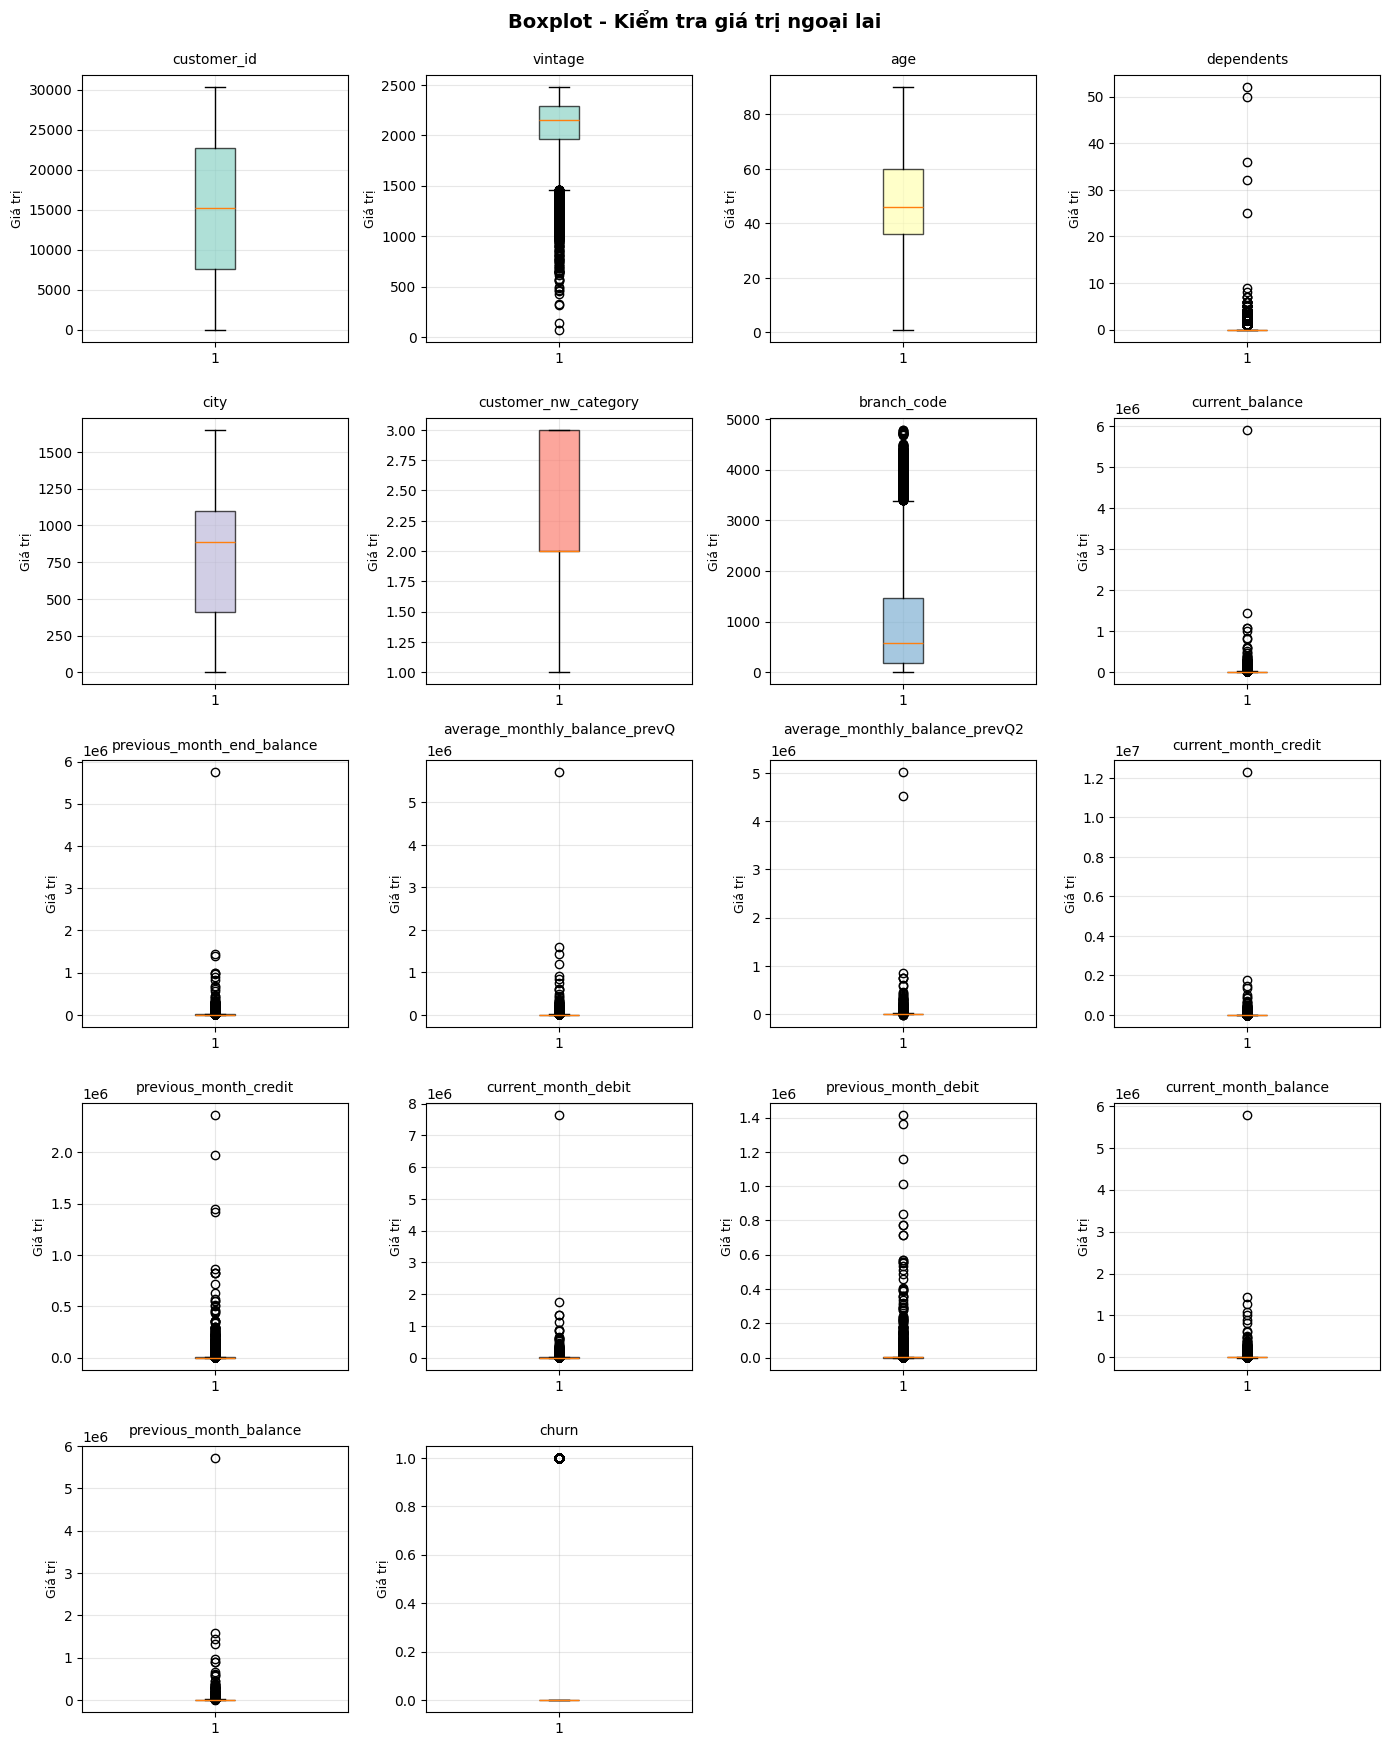

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import NumericType

# Lấy các cột số trong PySpark
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

print(f"Các cột số: {numeric_cols}")

# Convert sang Pandas để vẽ
df_pandas = df.select(numeric_cols).toPandas()

# Tính số hàng và cột cho subplot - 4 cột mỗi hàng
n_cols = len(numeric_cols)
n_plot_cols = 4
n_rows = (n_cols + n_plot_cols - 1) // n_plot_cols

# Tạo figure với kích thước phù hợp
fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(14, 3.5*n_rows))
fig.suptitle('Boxplot - Kiểm tra giá trị ngoại lai', fontsize=14, fontweight='bold', y=0.995)

# Flatten axes nếu có nhiều hơn 1 subplot
if n_cols > 1:
    axes = axes.flatten() if n_rows > 1 else axes
else:
    axes = [axes]

# Tạo danh sách màu sắc
colors = plt.cm.Set3(np.linspace(0, 1, n_cols))

# Vẽ boxplot cho từng cột với màu sắc khác nhau
for idx, col in enumerate(numeric_cols):
    bp = axes[idx].boxplot(df_pandas[col].dropna(), vert=True, patch_artist=True)
    # Tô màu cho box
    bp['boxes'][0].set_facecolor(colors[idx])
    bp['boxes'][0].set_alpha(0.7)
    axes[idx].set_title(f'{col}', fontsize=10, pad=8)
    axes[idx].set_ylabel('Giá trị', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Ẩn các subplot trống
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Xử lý Outlier: Log Transformation
from pyspark.sql.functions import log, col

# Danh sách 10 cột tài chính cần xử lý Log Transformation
LOG_TRANSFORM_COLS = [
    'current_balance',
    'previous_month_end_balance',
    'average_monthly_balance_prevQ',
    'average_monthly_balance_prevQ2',
    'current_month_credit',
    'previous_month_credit',
    'current_month_debit',
    'previous_month_debit',
    'current_month_balance',
    'previous_month_balance']

# Áp dụng Log(1 + X) cho từng cột
for c in LOG_TRANSFORM_COLS:
    new_col_name = f"{c}_log"
    # SỬA LỖI: Đảm bảo bạn gán lại vào df_encoded trong mỗi lần lặp.
    # Code này là chính xác, nhưng bạn cần đảm bảo nó là code bạn đã chạy.
    df = df.withColumn(
        new_col_name,
        log(col(c) + 1)
    )

df=df.drop( 'current_balance',
    'previous_month_end_balance',
    'average_monthly_balance_prevQ',
    'average_monthly_balance_prevQ2',
    'current_month_credit',
    'previous_month_credit',
    'current_month_debit',
    'previous_month_debit',
    'current_month_balance',
    'previous_month_balance')

print(" Đã tạo 10 cột Log-Transformed mới và xóa các cột cũ.")

# Bây giờ, các cột mới có đuôi '_log' sẽ được sử dụng thay thế
# cho các cột gốc trong bước VectorAssembler tiếp theo.

df.show(5)

 Đã tạo 10 cột Log-Transformed mới và xóa các cột cũ.
+-----------+-------+---+------+----------+-------------+----+--------------------+-----------+-----+-------------------+-------------------+------------------------------+---------------------------------+----------------------------------+------------------------+-------------------------+-----------------------+------------------------+-------------------------+--------------------------+
|customer_id|vintage|age|gender|dependents|   occupation|city|customer_nw_category|branch_code|churn|   last_transaction|current_balance_log|previous_month_end_balance_log|average_monthly_balance_prevQ_log|average_monthly_balance_prevQ2_log|current_month_credit_log|previous_month_credit_log|current_month_debit_log|previous_month_debit_log|current_month_balance_log|previous_month_balance_log|
+-----------+-------+---+------+----------+-------------+----+--------------------+-----------+-----+-------------------+-------------------+---------------

In [ ]:
# Xem thống kê cơ bản sau khi clean data và xử lý outlier
df.summary().show()

+-------+------------------+------------------+------------------+------+------------------+----------+-----------------+--------------------+-----------------+-------------------+--------------------+------------------------------+---------------------------------+----------------------------------+------------------------+-------------------------+-----------------------+------------------------+-------------------------+--------------------------+
|summary|       customer_id|           vintage|               age|gender|        dependents|occupation|             city|customer_nw_category|      branch_code|              churn| current_balance_log|previous_month_end_balance_log|average_monthly_balance_prevQ_log|average_monthly_balance_prevQ2_log|current_month_credit_log|previous_month_credit_log|current_month_debit_log|previous_month_debit_log|current_month_balance_log|previous_month_balance_log|
+-------+------------------+------------------+------------------+------+-----------------

In [ ]:
df_pandas.columns.tolist()

['customer_id',
 'vintage',
 'age',
 'dependents',
 'city',
 'customer_nw_category',
 'branch_code',
 'current_balance',
 'previous_month_end_balance',
 'average_monthly_balance_prevQ',
 'average_monthly_balance_prevQ2',
 'current_month_credit',
 'previous_month_credit',
 'current_month_debit',
 'previous_month_debit',
 'current_month_balance',
 'previous_month_balance',
 'churn']

**TRỰC QUAN HÓA DỮ LIỆU**

In [ ]:
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType

df_pandas = df.toPandas()

# Lấy các cột số và cột categorical
numeric_cols = [f.name for f in df.schema.fields
                if isinstance(f.dataType, (IntegerType, LongType, FloatType, DoubleType))]
categorical_cols = ['gender', 'occupation', 'city', 'customer_nw_category', 'branch_code']
print(numeric_cols)
print(categorical_cols)

['customer_id', 'vintage', 'age', 'dependents', 'city', 'customer_nw_category', 'branch_code', 'churn', 'current_balance_log', 'previous_month_end_balance_log', 'average_monthly_balance_prevQ_log', 'average_monthly_balance_prevQ2_log', 'current_month_credit_log', 'previous_month_credit_log', 'current_month_debit_log', 'previous_month_debit_log', 'current_month_balance_log', 'previous_month_balance_log']
['gender', 'occupation', 'city', 'customer_nw_category', 'branch_code']


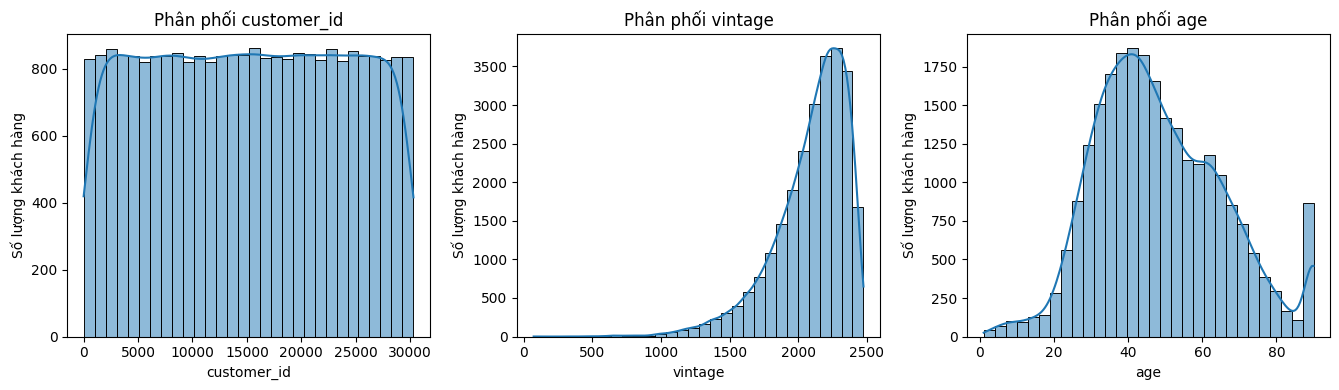

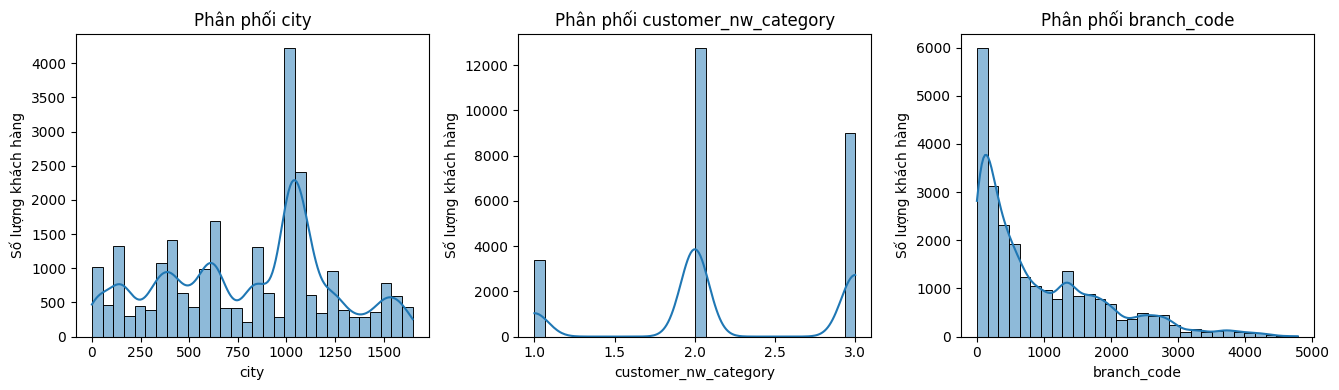

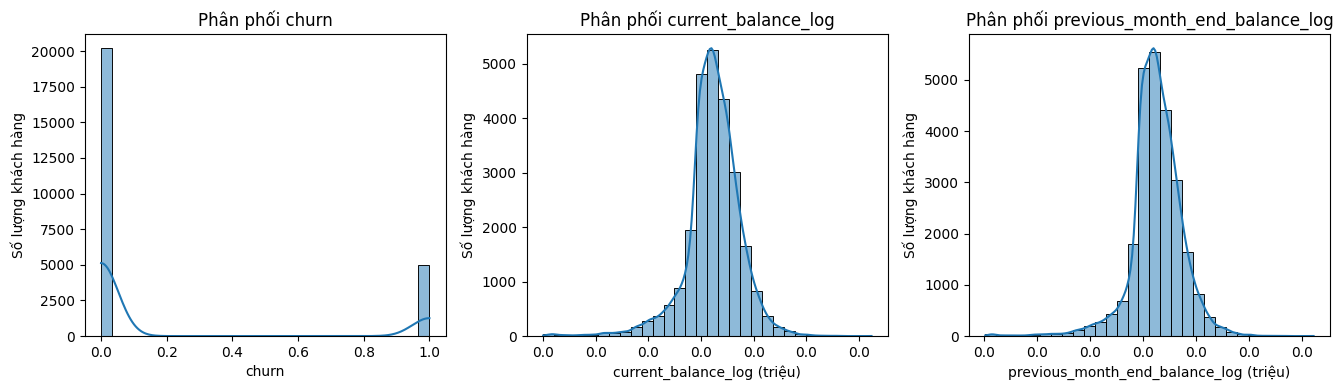

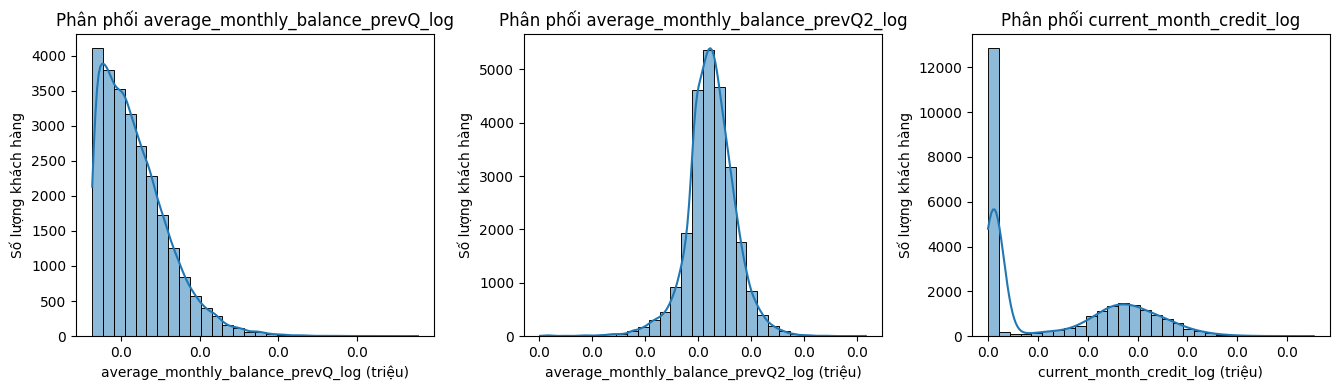

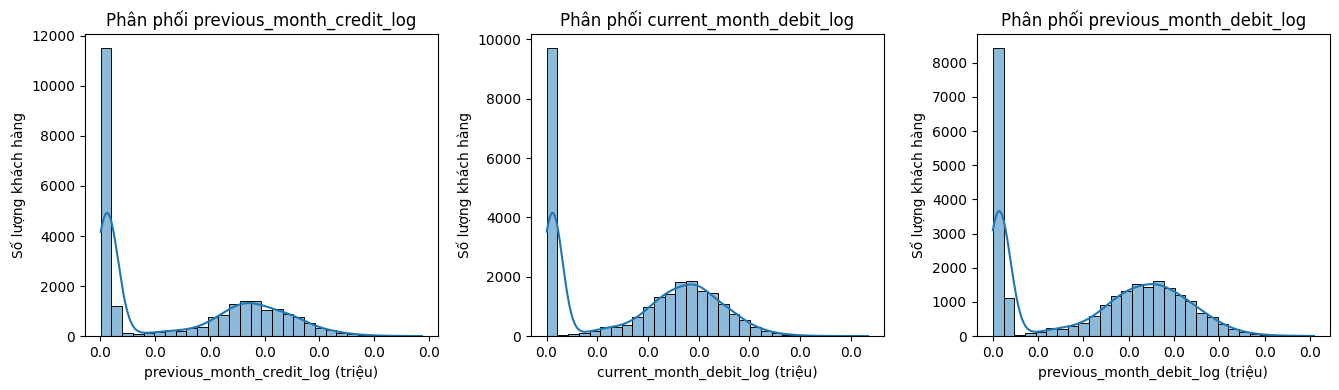

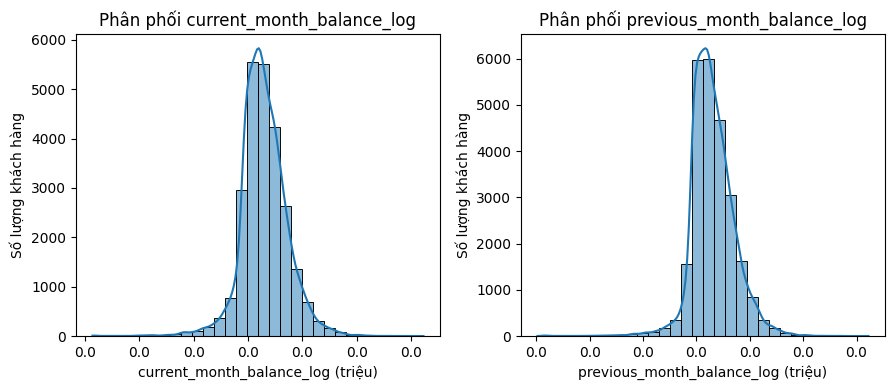

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

# CHỈ BỎ dependents — không ảnh hưởng các biểu đồ còn lại
skip_cols = ['dependents']

PLOTS_PER_ROW = 3

numeric_cols_to_plot = [
    col for col in numeric_cols
    if col in df_pandas.columns and col not in skip_cols
]

def chunk_list(data, size):
    for i in range(0, len(data), size):
        yield data[i:i + size]

FIXED_FIG_WIDTH = 4.5 * PLOTS_PER_ROW
FIXED_FIG_HEIGHT = 4

for group in chunk_list(numeric_cols_to_plot, PLOTS_PER_ROW):
    fig, axes = plt.subplots(nrows=1, ncols=PLOTS_PER_ROW,
                             figsize=(FIXED_FIG_WIDTH, FIXED_FIG_HEIGHT))
    axes = np.array(axes).flatten()

    if len(group) == 0:
        continue

    for i, col in enumerate(group):
        ax = axes[i]
        if any(keyword in col.lower() for keyword in
               ["balance", "amount", "income", "credit", "debit"]):
            sns.histplot(df_pandas[col].dropna() / 1e6, kde=True, bins=30, ax=ax)
            ax.set_xlabel(f"{col} (triệu)", fontsize=10)
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}'))
        else:
            sns.histplot(df_pandas[col].dropna(), kde=True, bins=30, ax=ax)
            ax.set_xlabel(col, fontsize=10)

        ax.set_title(f'Phân phối {col}', fontsize=12)
        ax.set_ylabel('Số lượng khách hàng', fontsize=10)

    for j in range(len(group), PLOTS_PER_ROW):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


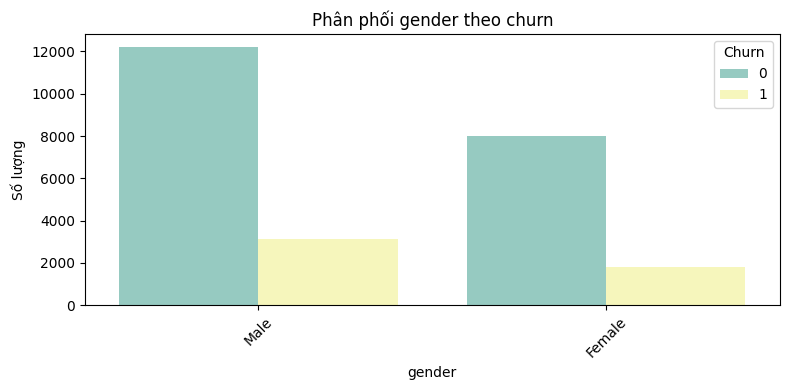

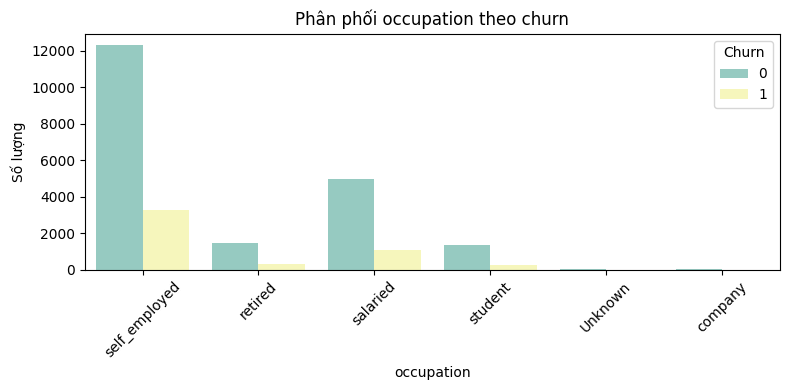

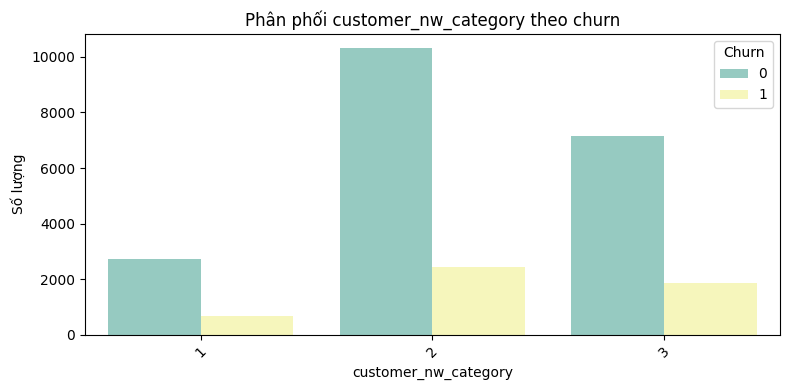

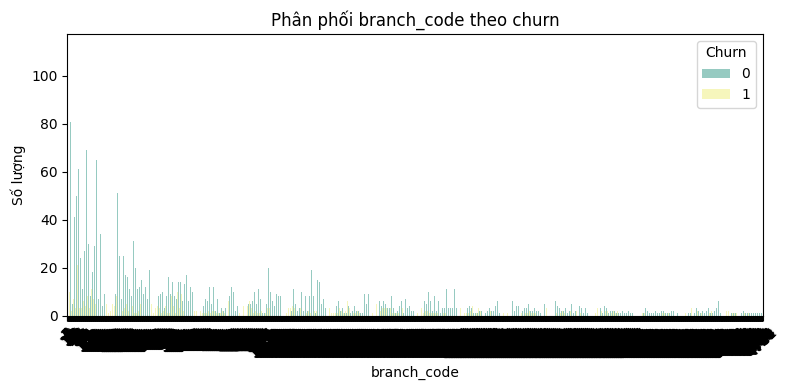

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loại bỏ city khỏi danh sách cột cần vẽ
categorical_cols_plot = [col for col in categorical_cols if col != 'city']

for col in categorical_cols_plot:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='churn', data=df_pandas, palette='Set3')
    plt.title(f'Phân phối {col} theo churn')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Số lượng')
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()


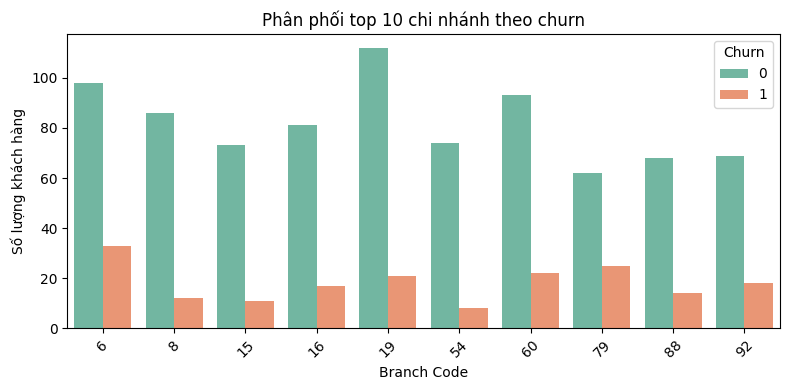

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy top 10 chi nhánh có nhiều khách hàng nhất
top_branches = df_pandas['branch_code'].value_counts().nlargest(10).index

plt.figure(figsize=(8,4))
sns.countplot(x='branch_code', hue='churn', data=df_pandas[df_pandas['branch_code'].isin(top_branches)], palette='Set2')
plt.title('Phân phối top 10 chi nhánh theo churn')
plt.xticks(rotation=45)
plt.xlabel('Branch Code')
plt.ylabel('Số lượng khách hàng')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()



/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


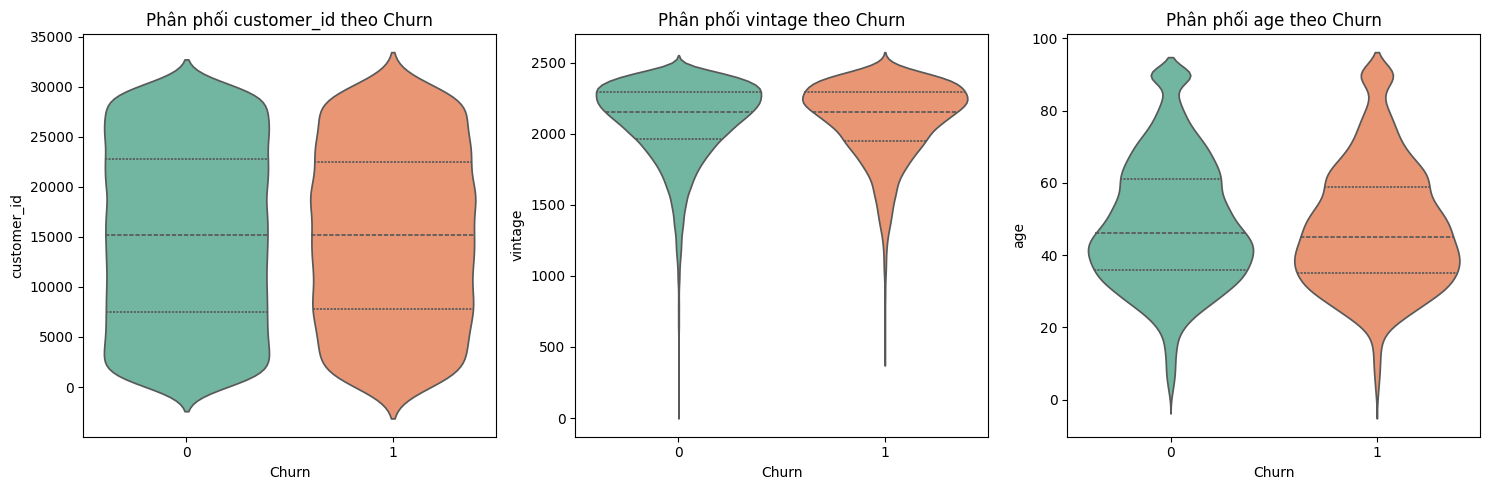

/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


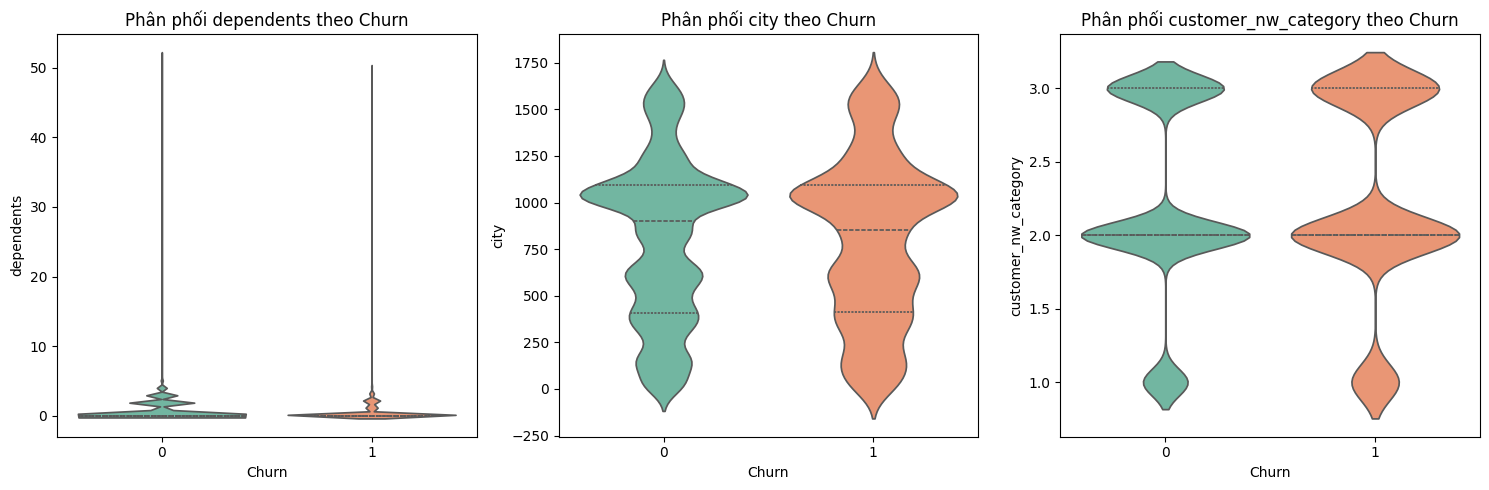

/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


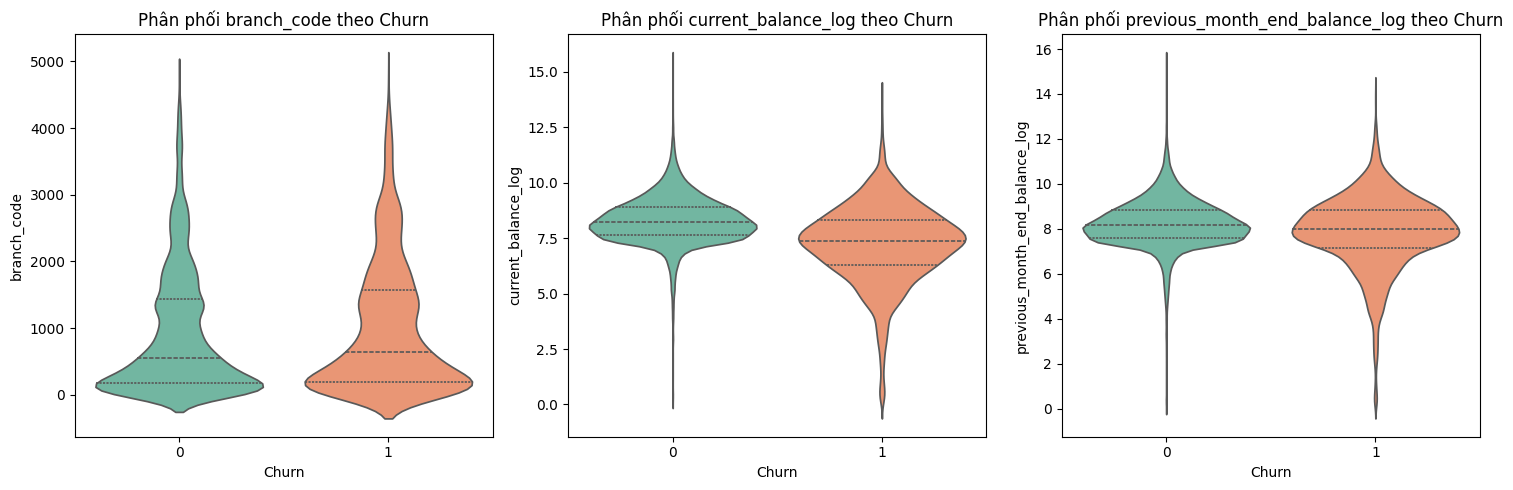

/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


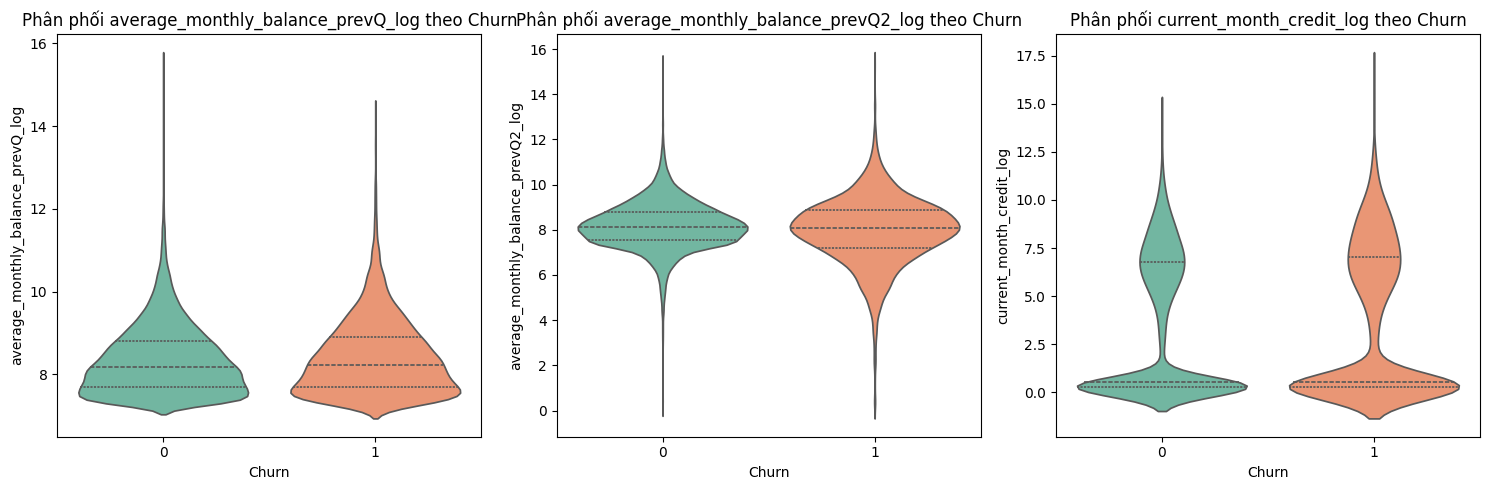

/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


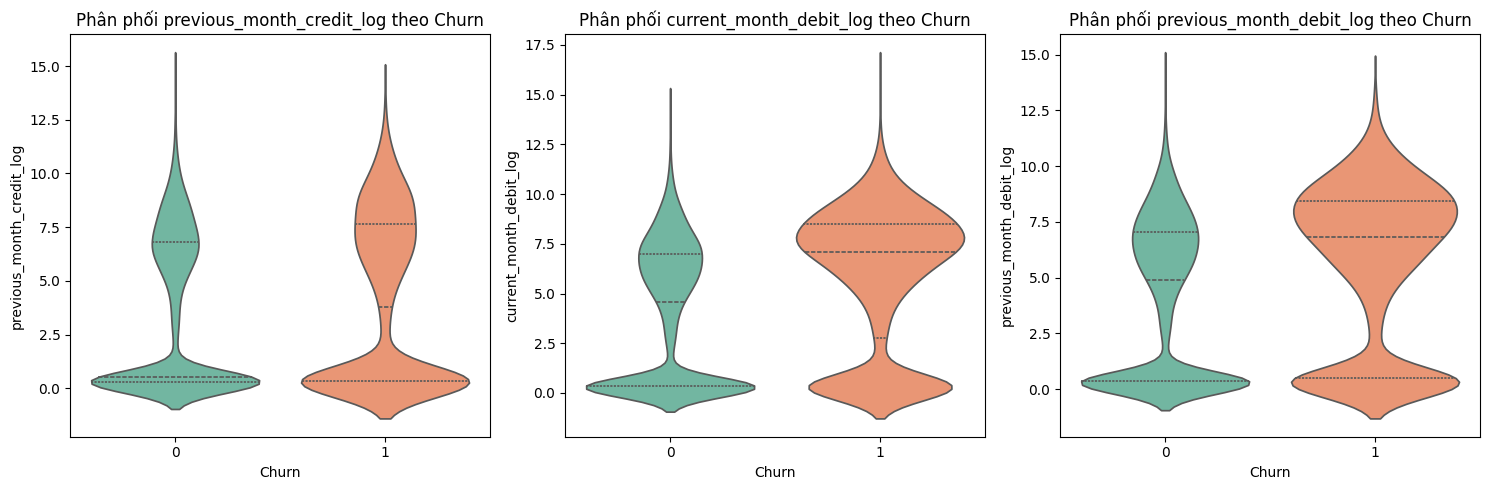

/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')
/tmp/ipython-input-3444897993.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')


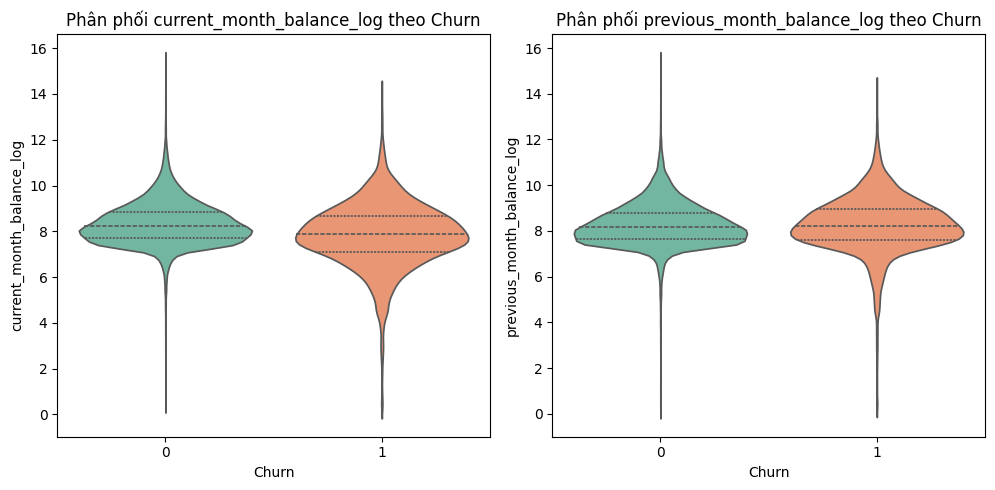

In [ ]:
# VIOLIN PLOT GIƯA CHURN VÀ CÁC BIẾN X
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CẤU HÌNH ---
# Số lượng hình bạn muốn vẽ trên mỗi hàng (Ví dụ: 3)
PLOTS_PER_ROW = 3
# Tên cột Categorical dùng làm trục X
CHURN_COL = 'churn'

# Lọc numeric_cols: chỉ giữ lại các cột tồn tại
# BƯỚC LỌC MỚI: Loại bỏ cột CHURN_COL khỏi danh sách các cột số cần vẽ
numeric_cols_to_plot = [col for col in numeric_cols
                        if col in df_pandas.columns and col != CHURN_COL] # <- Đã thêm điều kiện này!

# Hàm chia danh sách cột thành các phần có kích thước n
def chunk_list(data, size):
    """Chia danh sách thành các phần có kích thước bằng 'size'."""
    for i in range(0, len(data), size):
        yield data[i:i + size]

# Cố định kích thước Figure (Vùng chứa) cho n biểu đồ
FIXED_FIG_WIDTH = 5 * PLOTS_PER_ROW # Chiều rộng 5 inch/hình
FIXED_FIG_HEIGHT = 5

# Vòng lặp vẽ hình, xử lý n cột mỗi lần
for group in chunk_list(numeric_cols_to_plot, PLOTS_PER_ROW):

    # Tạo Figure và Axes. Luôn tạo PLOTS_PER_ROW cột để giữ kích thước cố định
    fig, axes = plt.subplots(
        nrows=1,
        ncols=PLOTS_PER_ROW,
        figsize=(FIXED_FIG_WIDTH, FIXED_FIG_HEIGHT)
    )

    # Đảm bảo 'axes' là một mảng 1 chiều để dễ lặp
    axes = np.array(axes).flatten()

    if len(group) == 0:
        continue

    for i, col in enumerate(group):
        ax = axes[i] # Chọn biểu đồ con hiện tại

        # --- Logic vẽ Violin Plot ---
        sns.violinplot(x=CHURN_COL, y=col, data=df_pandas, palette='Set2', ax=ax, inner='quartile')

        ax.set_title(f'Phân phối {col} theo Churn', fontsize=12)
        ax.set_xlabel('Churn', fontsize=10)
        ax.set_ylabel(col, fontsize=10)

    # Xử lý các biểu đồ con không dùng đến ở nhóm cuối cùng
    for j in range(len(group), PLOTS_PER_ROW):
        axes[j].set_visible(False)

    # Điều chỉnh khoảng cách giữa các biểu đồ con
    plt.tight_layout()
    plt.show()

**TẠO MODEL VÀ DỰ ĐOÁN**

Tìm thấy 2 cột categorical: ['gender', 'occupation']
Tìm thấy 18 cột numeric: ['customer_id', 'vintage', 'age', 'dependents', 'city', 'customer_nw_category', 'branch_code', 'churn', 'current_balance_log', 'previous_month_end_balance_log', 'average_monthly_balance_prevQ_log', 'average_monthly_balance_prevQ2_log', 'current_month_credit_log', 'previous_month_credit_log', 'current_month_debit_log', 'previous_month_debit_log', 'current_month_balance_log', 'previous_month_balance_log']

Đã encode xong các cột categorical bằng One-Hot Encoding


Đã tính xong correlation matrix với 26 features, bắt đầu vẽ...


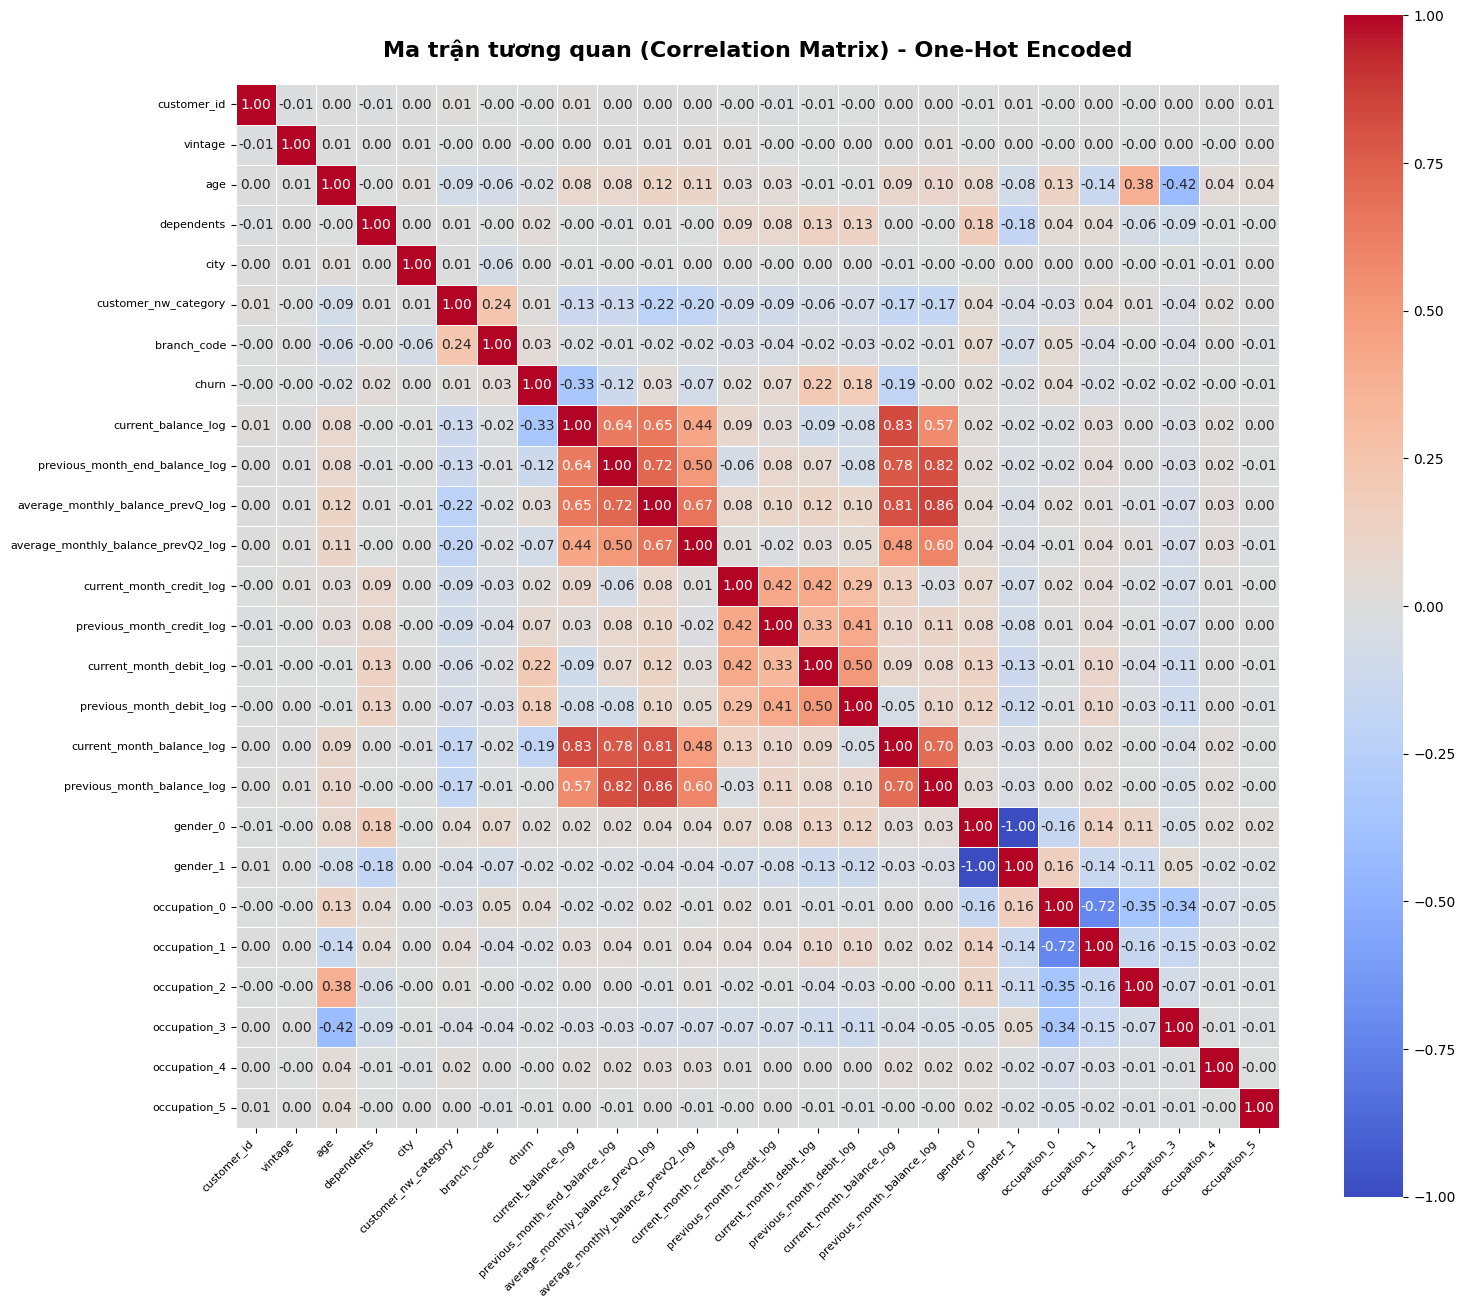


=== Top cặp biến có correlation cao nhất ===
                             var1                               var2  correlation
                         gender_0                           gender_1    -1.000000
average_monthly_balance_prevQ_log         previous_month_balance_log     0.858726
              current_balance_log          current_month_balance_log     0.834344
   previous_month_end_balance_log         previous_month_balance_log     0.817106
average_monthly_balance_prevQ_log          current_month_balance_log     0.805507
   previous_month_end_balance_log          current_month_balance_log     0.779839
   previous_month_end_balance_log  average_monthly_balance_prevQ_log     0.722027
                     occupation_0                       occupation_1    -0.718994
        current_month_balance_log         previous_month_balance_log     0.695809
average_monthly_balance_prevQ_log average_monthly_balance_prevQ2_log     0.666722
              current_balance_log  average_monthly_b

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.types import NumericType, IntegerType, LongType, FloatType, DoubleType, StringType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml import Pipeline

# Bỏ last_transaction vì cùng ý nghĩa với cột vintage; bên cạnh đó là định dạng ngày nên khó dùng để encoding cũng như dự báo
df = df.drop("last_transaction")

# Lấy các cột categorical và numeric
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
numeric_cols = [f.name for f in df.schema.fields
                if isinstance(f.dataType, (IntegerType, LongType, FloatType, DoubleType))]

print(f"Tìm thấy {len(categorical_cols)} cột categorical: {categorical_cols}")
print(f"Tìm thấy {len(numeric_cols)} cột numeric: {numeric_cols}")

# One-Hot Encoding cho các cột categorical
stages = []
encoded_cols = []

for col_name in categorical_cols:
    # StringIndexer
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed", handleInvalid="keep")
    # OneHotEncoder
    encoder = OneHotEncoder(inputCol=f"{col_name}_indexed", outputCol=f"{col_name}_encoded")
    stages += [indexer, encoder]
    encoded_cols.append(f"{col_name}_encoded")

# Tạo pipeline
pipeline = Pipeline(stages=stages)
df_encoded = pipeline.fit(df).transform(df)

print("\nĐã encode xong các cột categorical bằng One-Hot Encoding\n")

# Assemble tất cả features (numeric + one-hot encoded)
all_features = numeric_cols + encoded_cols
assembler = VectorAssembler(inputCols=all_features, outputCol="features", handleInvalid="skip")
df_vector = assembler.transform(df_encoded)

# Tính correlation matrix trong PySpark
correlation_matrix_spark = Correlation.corr(df_vector, "features", "pearson").head()[0]

# Convert sang numpy array
correlation_array = correlation_matrix_spark.toArray()

# Tạo tên cột cho correlation matrix (bao gồm cả one-hot features)
feature_names = numeric_cols.copy()
for col_name in categorical_cols:
    # Lấy số lượng categories
    n_categories = df_encoded.select(f"{col_name}_encoded").first()[0].size
    for i in range(n_categories):
        feature_names.append(f"{col_name}_{i}")

# Tạo DataFrame pandas để vẽ
correlation_matrix = pd.DataFrame(
    correlation_array,
    columns=feature_names,
    index=feature_names
)

print(f"\nĐã tính xong correlation matrix với {len(feature_names)} features, bắt đầu vẽ...")

# Vẽ heatmap (điều chỉnh kích thước theo số features)
fig_size = max(9, len(feature_names) * 0.6)
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Ma trận tương quan (Correlation Matrix) - One-Hot Encoded', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# In ra các cặp có correlation cao
print("\n=== Top cặp biến có correlation cao nhất ===")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'var1': correlation_matrix.columns[i],
            'var2': correlation_matrix.columns[j],
            'correlation': correlation_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False, key=abs)
print(corr_df.head(11).to_string(index=False))

In [ ]:
df_encoded.show(5)

+-----------+-------+---+------+----------+-------------+----+--------------------+-----------+-----+-------------------+------------------------------+---------------------------------+----------------------------------+------------------------+-------------------------+-----------------------+------------------------+-------------------------+--------------------------+--------------+--------------+------------------+------------------+
|customer_id|vintage|age|gender|dependents|   occupation|city|customer_nw_category|branch_code|churn|current_balance_log|previous_month_end_balance_log|average_monthly_balance_prevQ_log|average_monthly_balance_prevQ2_log|current_month_credit_log|previous_month_credit_log|current_month_debit_log|previous_month_debit_log|current_month_balance_log|previous_month_balance_log|gender_indexed|gender_encoded|occupation_indexed|occupation_encoded|
+-----------+-------+---+------+----------+-------------+----+--------------------+-----------+-----+-------------

In [ ]:
#drop các cột không cần thiết sau OHE
df_encoded = df_encoded.drop("gender","occupation")

/tmp/ipython-input-1938397227.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette='coolwarm', orient='h')


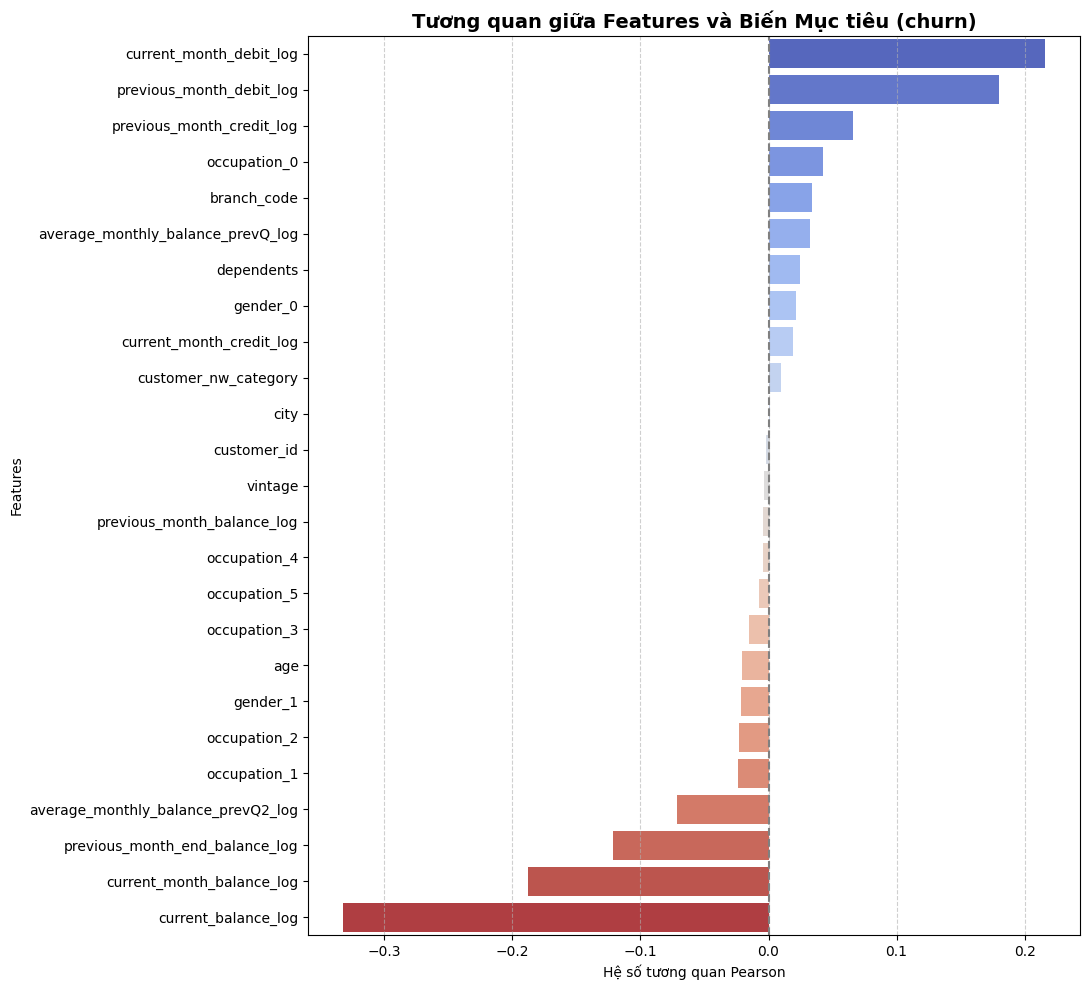


Đã hiển thị biểu đồ cột tương quan giữa 25 features còn lại và biến mục tiêu 'churn'.


In [ ]:
# TƯƠNG QUAN GIỮA BIẾN PHỤ THUỘC CHURN VÀ CÁC BIẾN X
TARGET_COL = 'churn'
df_processed = df_encoded

# Cập nhật danh sách features còn lại (trừ cột target và các cột đã drop)
current_cols = df_processed.columns
# Cần tái tạo lại danh sách features đã được truyền vào VectorAssembler để đảm bảo tính nhất quán
numeric_cols_final = [col for col in numeric_cols
                      if col in current_cols and col != TARGET_COL]
encoded_cols_final = [col for col in [f"{col}_encoded" for col in categorical_cols]
                      if col in current_cols]
all_features = numeric_cols_final + encoded_cols_final

# TÍNH TOÁN VÀ VẼ BIỂU ĐỒ CỘT TƯƠNG QUAN VỚI CHURN

# Assemble features và target vào một Vector
all_cols_for_corr = all_features + [TARGET_COL]
assembler_corr = VectorAssembler(inputCols=all_cols_for_corr, outputCol="all_features_vector", handleInvalid="skip")
df_vector_corr = assembler_corr.transform(df_processed)

# Tính correlation matrix
correlation_matrix_spark = Correlation.corr(df_vector_corr, "all_features_vector", "pearson").head()[0]
correlation_array = correlation_matrix_spark.toArray()

# Tạo tên cột cho matrix (KHÔNG CẦN BƯỚC LOẠI BỎ gender_1 Ở ĐÂY NỮA)
feature_names_corr = numeric_cols_final.copy()
for col_name in categorical_cols:
    try:
        if f"{col_name}_encoded" in current_cols:
            n_categories = df_processed.select(f"{col_name}_encoded").first()[0].size
            # Nếu gender_1 đã bị loại bỏ, ta giả định bạn chỉ còn lại n_categories - 1 feature
            for i in range(n_categories):
                feature_names_corr.append(f"{col_name}_{i}")
    except Exception:
        pass

feature_names_corr.append(TARGET_COL)

# Tạo DataFrame pandas
correlation_matrix_full = pd.DataFrame(
    correlation_array,
    columns=feature_names_corr,
    index=feature_names_corr
)

# Trích xuất tương quan với biến mục tiêu (churn)
churn_corr = correlation_matrix_full[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)

# Vẽ biểu đồ cột
plt.figure(figsize=(11, max(5, len(churn_corr) * 0.4)))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette='coolwarm', orient='h')

plt.title(f'Tương quan giữa Features và Biến Mục tiêu ({TARGET_COL})', fontsize=14, fontweight='bold')
plt.xlabel('Hệ số tương quan Pearson', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.axvline(0, color='grey', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"\nĐã hiển thị biểu đồ cột tương quan giữa {len(churn_corr)} features còn lại và biến mục tiêu '{TARGET_COL}'.")

In [ ]:
df_encoded.show(5)

+-----------+-------+---+----------+----+--------------------+-----------+-----+-------------------+------------------------------+---------------------------------+----------------------------------+------------------------+-------------------------+-----------------------+------------------------+-------------------------+--------------------------+--------------+--------------+------------------+------------------+
|customer_id|vintage|age|dependents|city|customer_nw_category|branch_code|churn|current_balance_log|previous_month_end_balance_log|average_monthly_balance_prevQ_log|average_monthly_balance_prevQ2_log|current_month_credit_log|previous_month_credit_log|current_month_debit_log|previous_month_debit_log|current_month_balance_log|previous_month_balance_log|gender_indexed|gender_encoded|occupation_indexed|occupation_encoded|
+-----------+-------+---+----------+----+--------------------+-----------+-----+-------------------+------------------------------+-------------------------

In [ ]:
# Với Biểu đồ trên bỏ được các biến tương quan thấp. Còn lại:
FINAL_FEATURES = [
 'current_balance_log',
 'previous_month_end_balance_log',
 'average_monthly_balance_prevQ2_log',
 'previous_month_credit_log',
 'current_month_debit_log',
 'previous_month_debit_log',
 'current_month_balance_log']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def expand_vector_column(df, col_name):
    """Mở rộng cột vector PySpark thành nhiều cột số Pandas, điền NaN bằng 0.0."""
    # Chuyển đổi SparseVector/DenseVector sang numpy array
    vecs = df[col_name].apply(lambda x: x.toArray() if hasattr(x, "toArray") else np.array(x))

    # Tạo DataFrame từ các mảng/list
    expanded = pd.DataFrame(vecs.tolist(), index=df.index)
    expanded.columns = [f"{col_name}_{i}" for i in range(expanded.shape[1])]

    for col in expanded.columns:
        # Chuyển đổi sang số và điền NaN bằng 0.0
        expanded[col] = pd.to_numeric(expanded[col], errors='coerce').fillna(0.0)

    df = pd.concat([df.drop(columns=[col_name]), expanded], axis=1)
    return df


# 1. Tính toán giá trị trung bình (Mean) cho từng cột
# df_encoded là DataFrame PySpark chứa các cột _log
means = df_encoded.select(*FINAL_FEATURES).agg(
    *[F.mean(F.col(c)).alias(c) for c in FINAL_FEATURES]
).collect()[0].asDict()

# 2. Thay thế giá trị Null bằng giá trị Mean đã tính
df_imputed = df_encoded.na.fill(means)

print(" Đã xử lý Nulls bằng giá trị Trung bình (Mean).")

# 2. Gom tất cả các cột
assembler = VectorAssembler(inputCols=FINAL_FEATURES, outputCol="features_raw")
df_assembled = assembler.transform(df_imputed)

print("--- Bỏ qua bước Standard Scaling ---")

## 2. Chuyển sang Pandas và Bung Vector
# Lấy DataFrame ĐÃ ASSEMBLE (chứa features_raw) và cột churn
df_pandas = df_assembled.select("features_raw", "churn").toPandas()

# Bung cột vector features_raw (chứa các cột _log đã impute + các cột OHE)
df_pandas = expand_vector_column(df_pandas, "features_raw")

## 3. Huấn luyện Mô hình
# Tách X, y
X = df_pandas.drop("churn", axis=1)
y = df_pandas["churn"]

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Đảm bảo không còn NaN nào từ quá trình bung vector:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())
print(" Đã xử lý NaN cuối cùng trên tập huấn luyện.")

# Khai báo các mô hình (Thêm LR và class_weight như đã thảo luận)
models = {
    "LogisticRegression": LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=1),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5), # KNN sẽ bị ảnh hưởng nặng nhất khi bỏ scaling
    "SVC_RBF": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

# Train và đánh giá
results = []
best_f1 = -1.0
best_recall_of_best_f1 = 0.0
best_model_name = None

for name, model in models.items():
    print(f"\nTraining model: {name}")

    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Tính toán các chỉ số
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    })
    # Cập nhật best model
    if f1 > best_f1:
        best_f1 = f1
        best_recall_of_best_f1 = rec
        best_model_name = name
    elif f1 == best_f1 and rec > best_recall_of_best_f1:
        best_f1 = f1
        best_recall_of_best_f1 = rec
        best_model_name = name

# Bảng tổng hợp kết quả:
results_df = pd.DataFrame(results).sort_values(by=["F1", "Recall"], ascending=False)
print("\n" + "="*50)
print("Bảng so sánh mô hình (Dữ liệu Log, Impute, BỎ Scaling):")
print("="*50)
print(results_df.round(4).to_string(index=False))
print(f"\nBest model (Tối ưu F1 với ngưỡng 0.5): {best_model_name} (F1 = {best_f1:.4f}, Recall = {best_recall_of_best_f1:.4f})")

 Đã xử lý Nulls bằng giá trị Trung bình (Mean).
--- Bỏ qua bước Standard Scaling ---
 Đã xử lý NaN cuối cùng trên tập huấn luyện.

Training model: LogisticRegression

Training model: RandomForest

Training model: GradientBoosting

Training model: XGBoost

Training model: KNeighbors

Training model: SVC_RBF

Bảng so sánh mô hình (Dữ liệu Log, Impute, BỎ Scaling):
             Model  Accuracy  Precision  Recall     F1    AUC
           SVC_RBF    0.7750     0.4519  0.6623 0.5372 0.8000
  GradientBoosting    0.8448     0.6750  0.4103 0.5103 0.8037
           XGBoost    0.8317     0.6043  0.4234 0.4979 0.7817
LogisticRegression    0.7337     0.3954  0.6633 0.4955 0.7484
      RandomForest    0.8396     0.6614  0.3821 0.4843 0.8001
        KNeighbors    0.8309     0.6150  0.3800 0.4698 0.7436

Best model (Tối ưu F1 với ngưỡng 0.5): SVC_RBF (F1 = 0.5372, Recall = 0.6623)


In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------------------
# 1. SMOTE
# ----------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ----------------------
# 2. Scaling + PCA
# ----------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

pca = None
if X_train_scaled.shape[1] > 50:
    pca = PCA(n_components=30, random_state=42)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

# ----------------------
# 3. Train base models
# ----------------------
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=1, n_estimators=100)

models_resampled = {
    "RandomForest": rf_model,
    "GradientBoosting": gb_model,
    "XGBoost": xgb_model
}

for name, model in models_resampled.items():
    model.fit(X_train_res, y_train_res)

# ----------------------
# 4. Weighted soft voting ensemble
# ----------------------
ensemble = VotingClassifier(
    estimators=[("RandomForest", rf_model),
                ("GradientBoosting", gb_model),
                ("XGBoost", xgb_model)],
    voting='soft',
    weights=[1, 1.3, 1.5]
)
ensemble.fit(X_train_res, y_train_res)

# ----------------------
# 5. Threshold tuning grid search
# ----------------------
target_precision = 0.65
tuning_summary = []

all_models = list(models_resampled.items()) + [("Ensemble", ensemble)]

for name, model in all_models:
    X_input = X_test if name not in ["KNN","SVC_RBF"] else X_test_scaled
    y_prob = model.predict_proba(X_input)[:,1]
    thresholds = np.arange(0.68, 0.951, 0.001)

    best_threshold = 0.5
    best_f1 = 0
    best_precision = 0
    best_recall = 0

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        if precision >= target_precision and f1 > best_f1:
            best_threshold = t
            best_f1 = f1
            best_precision = precision
            best_recall = recall

    if best_f1 == 0:
        best_threshold = thresholds[np.argmax([precision_score(y_test, (y_prob >= t).astype(int)) for t in thresholds])]
        best_pred = (y_prob >= best_threshold).astype(int)
        best_precision = precision_score(y_test, best_pred)
        best_recall = recall_score(y_test, best_pred)
        best_f1 = f1_score(y_test, best_pred)
        note = "Precision cao nhất (không đạt target)"
    else:
        note = f"Precision ≥ {target_precision:.2f}"

    tuning_summary.append({
        "Model": name,
        "Threshold": round(best_threshold,3),
        "Precision": round(best_precision,4),
        "Recall": round(best_recall,4),
        "F1": round(best_f1,4)
    })

# ----------------------
# 6. Sắp xếp bảng kết quả theo "tối ưu nhất"
# ----------------------
tuning_summary_df = pd.DataFrame(tuning_summary)
tuning_summary_df["Precision_ok"] = tuning_summary_df["Precision"] >= target_precision

tuning_summary_df = tuning_summary_df.sort_values(
    by=["Precision_ok", "F1", "Precision"],
    ascending=[False, False, False]
).drop(columns=["Precision_ok"]).reset_index(drop=True)

print("\nBẢNG TỔNG HỢP MÔ HÌNH THEO NGƯỠNG TỐI ƯU")
print(tuning_summary_df.to_string(index=False))

# ----------------------
# 7. Lưu best model + threshold
# ----------------------
best_model_name = tuning_summary_df.loc[0, "Model"]
best_threshold = tuning_summary_df.loc[0, "Threshold"]

if best_model_name == "Ensemble":
    best_model = ensemble
else:
    best_model = models_resampled[best_model_name]

print(f"\nBest model: {best_model_name} với threshold = {best_threshold}")





# Vì kết quả sử dụng 3 mô hình (ít nhạy cảm) nên không cần áp dụng scaling và pca khi xuất file pkl không nên thêm 2 lệnh này vô
# Tránh ép buộc dữ liệu scaling và pca làm sai lệch dữ liệu, trong khi mô hình không cần


BẢNG TỔNG HỢP MÔ HÌNH THEO NGƯỠNG TỐI ƯU
           Model  Threshold  Precision  Recall     F1
        Ensemble      0.757     0.6523  0.4123 0.5053
GradientBoosting      0.797     0.6611  0.4012 0.4994
         XGBoost      0.806     0.6614  0.3821 0.4843
    RandomForest      0.770     0.6552  0.3085 0.4195

Best model: Ensemble với threshold = 0.757


In [ ]:
import joblib
import os
from sklearn.pipeline import Pipeline, FunctionTransformer

# --- HÀM XỬ LÝ CUỐI CÙNG: BUNG VECTOR VÀ ĐIỀN NA ---
def preprocess_final_features(df_with_raw_features):
    """
    Nhận df đã có cột 'features_raw', bung vector, điền NaN
    """
    df_processed = expand_vector_column(df_with_raw_features, "features_raw")
    return df_processed.drop(columns=["churn"], errors='ignore').fillna(0)

# --- Transformer từ hàm trên ---
preprocessor = FunctionTransformer(preprocess_final_features)

# --- Build pipeline end-to-end ---
steps = [("final_vector_expansion", preprocessor)]
steps.append(("model", best_model))  # model đã fit

deploy_pipeline = Pipeline(steps)

# --- Lưu pipeline + threshold + thông tin quan trọng ---
pipeline_to_save = {
    "pipeline": deploy_pipeline,
    "threshold": best_threshold,   # threshold tối ưu đã chọn
    "FINAL_FEATURES": FINAL_FEATURES,  # danh sách features sử dụng
    "impute_means": means            # giá trị mean dùng để impute null
}

pipeline_path = "best_model_churn.pkl"
joblib.dump(pipeline_to_save, pipeline_path, compress=3)

# --- Kiểm tra file ---
file_size_mb = os.path.getsize(pipeline_path) / (1024*1024)
print(f" Pipeline end-to-end đã lưu: {pipeline_path}")
print(f"Kích thước file: {file_size_mb:.2f} MB")
print(f"Best model: {best_model_name}, threshold = {best_threshold:.3f}")

if file_size_mb < 0.1:
    print(" Cảnh báo: File quá nhỏ, kiểm tra xem model đã fit chưa.")

# --- Ghi chú khi triển khai ---
print("Lưu ý triển khai:")
print("1. Dữ liệu đầu vào phải được PySpark xử lý Log/OHE và VectorAssembler để tạo 'features_raw'.")
print("2. Sau khi predict_proba, áp dụng threshold =", best_threshold)

try:
    from google.colab import files
    files.download(pipeline_path)
except:
    print("File pipeline đã sẵn sàng trong thư mục làm việc.")

 Pipeline end-to-end đã lưu: best_model_churn.pkl
Kích thước file: 25.30 MB
Best model: Ensemble, threshold = 0.757
Lưu ý triển khai:
1. Dữ liệu đầu vào phải được PySpark xử lý Log/OHE và VectorAssembler để tạo 'features_raw'.
2. Sau khi predict_proba, áp dụng threshold = 0.757


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>